In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.eye_data import EyeData
import pandas as pd

from ephysvibe.structures.lfp_data import LfpData
from ephysvibe.spike_sorting import config
import h5py

In [2]:
# %matplotlib widget

In [11]:
sp_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/lip/spikes/2023-03-03_10-59-32_Riesling_lip_e1_r1_sp.h5"
neu_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/2023-03-03_10-59-32_Riesling_v4_e1_r1_mua7_neu.h5"
bhv_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/bhv/2023-03-03_10-59-32_Riesling_e1_r1_bhv.h5"
eye_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/eye/2022-11-22_10-59-03_Riesling_e1_r1_eye.h5"

In [4]:
eye_data = EyeData.from_python_hdf5(eye_path)

In [5]:
eye_data.trial_error

array([0., 5., 0., ..., 4., 4., 3.])

In [6]:
eye_data.code_numbers[0]

array([  9.,  35.,   8.,  37., 122.,  38.,  36.,  10.,  10.,  10.,  40.,
        56.,  18.,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [7]:
eye_data.code_samples[0][12]

3527.0

In [8]:
eye_data.code_samples[0][12]-eye_data.code_samples[0][0]

2527.0

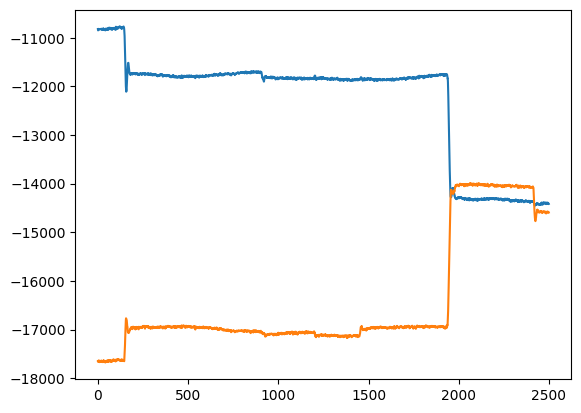

In [9]:
plt.plot(eye_data.eye[0][0][1000:3500])
plt.plot(eye_data.eye[0][1][1000:3500])

In [46]:
np.sum(~np.isnan(eye_data.eye_ml[0][0]))

2535

In [47]:
eye_data.code_samples[0][12]-eye_data.code_samples[0][0]

2527.0

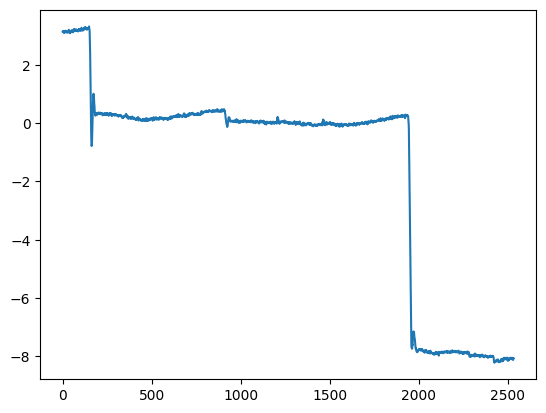

In [127]:
plt.plot(eye_data.eye_ml[0][0])
# plt.plot(eye_data.eye_ml[0][1])
#plt.plot(eye_data.eye[0][0][1000:3500]/1000+12)

In [102]:
def conv_oe_eyes(eye,eye_ml,i_axis=1):
    #len_dif = np.count_nonzero(~np.isnan(eye))-np.count_nonzero(~np.isnan(eye_ml))
    zero = np.nanargmin(np.abs(eye_ml)) # closest point to zero
    tmp = np.where(np.abs(eye_ml)<=1)[0] # closest point to 1
    if tmp.shape[0] == 0:
        return np.array([])
    one = tmp[np.nanargmin(eye_ml[tmp])] # first point close to 1
    mf = 1
    if eye_ml[one]<0 and i_axis == 1:
        mf = -1       
    oezero = eye[zero]
    oeone = eye[one]
    #print(oezero,oeone,len_dif)
    slope = oeone - oezero
    # plt.plot(eye_ml)
    # plt.plot(mf*(eye_data.eye[i_trial,i_axis,len_dif:]-oezero)/np.abs(slope))
    return (mf*(eye-oezero)/np.abs(slope))#[int(trial_s_on-len_dif-200):]

In [123]:
x_eye_ml = eye_data.eye_ml[0][0]
len = np.sum(~np.isnan(x_eye_ml))
x_eye = eye_data.eye[0][0][1000:len+1000]

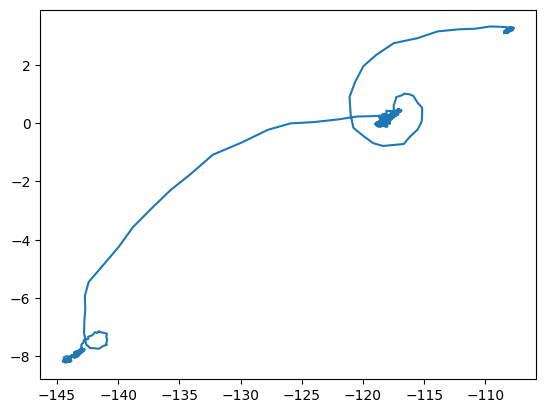

In [145]:
plt.plot(x_eye/100,x_eye_ml[:len])

In [131]:
slope

8.0

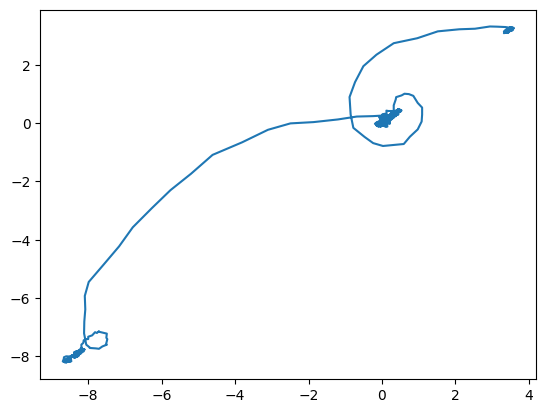

In [136]:
plt.plot(mf*(x_eye-oezero)/np.abs(300),x_eye_ml[:len])

In [142]:
i_axis=0
zero = np.nanargmin(np.abs(x_eye_ml)) # closest point to zero
tmp = np.where(np.abs(x_eye_ml)<=1)[0] # closest point to 1

one = tmp[np.nanargmax(np.abs(x_eye_ml[tmp]))] # first point close to 1
mf = 1
if x_eye_ml[one]<0 and i_axis == 1:
    mf = -1       
oezero = x_eye[zero]
oeone = x_eye[one]
#print(oezero,oeone,len_dif)
slope = oeone - oezero

In [143]:
slope

220.0

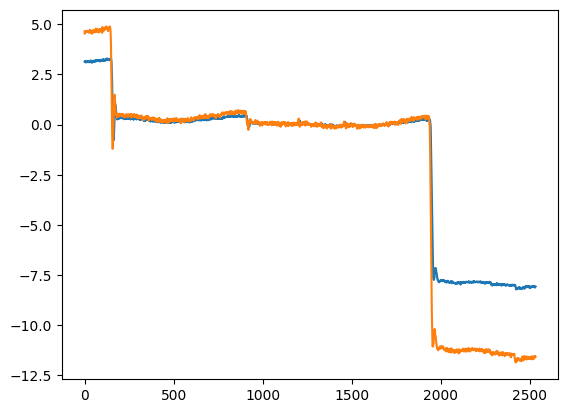

In [144]:
plt.plot(x_eye_ml)
plt.plot((mf*(x_eye-oezero)/np.abs(slope)))

In [117]:

c_eye = conv_oe_eyes(x_eye,x_eye_ml,i_axis=0)

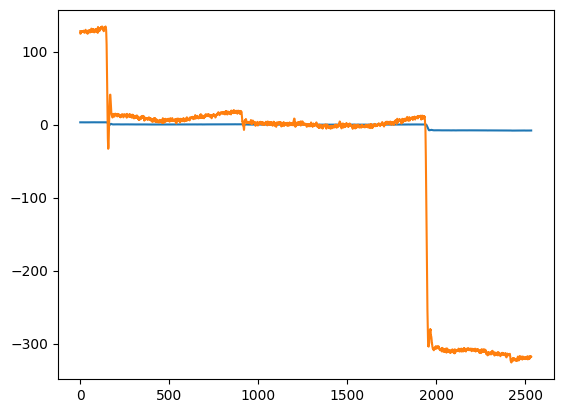

In [118]:
plt.plot(x_eye_ml)
plt.plot(c_eye)

In [12]:
bhv = BhvData.from_python_hdf5(bhv_path)
sp_data = SpikeData.from_python_hdf5(sp_path)

In [13]:
neu_data = NeuronData.from_python_hdf5(neu_path)

In [14]:
neu_data.sp_samples.shape

(1034, 15198)

In [15]:
neu_data.pos_code

array([121., 123., 123., ...,  -1.,   1.,   1.])

In [16]:
neu_data.date_time

'2023-03-03_10-59-32'

In [17]:
# select correct trials, block one, inside RF, and align with sample onset 
sp_sample_on,mask_in = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= 1,
    select_pos= 1,
    event ="sample_on",
    time_before = 500,
    correct_trials= True,
)
sp_sample_on_in = sp_sample_on[:,300:1200]

TypeError: align_on() got an unexpected keyword argument 'correct_trials'

In [ ]:
sp_sample_on_in

In [12]:
sample_id = neu_data.sample_id[mask_in]
o1_c1_idx_in, o1_c5_idx_in, o5_c1_idx_in, o5_c5_idx_in, o0_c0_idx_in = select_trials.get_trials_by_sample(sample_id)

In [13]:
o1_c1_idx_in

array([  3,   4,   5,  10,  12,  19,  27,  31,  34,  36,  43,  45,  47,
        56,  59,  62,  63,  65,  74,  76,  78,  82,  86,  94,  98, 102,
       115, 117, 118, 127, 132, 133, 141, 147, 156, 163, 179, 182, 184,
       185, 201, 203, 208, 212, 218, 222, 224, 228, 240, 244, 268])

/tmp/ipykernel_141867/4017640199.py:5: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cols,rows+60*i, marker='|', alpha=1,edgecolors='none',color=colors[i])


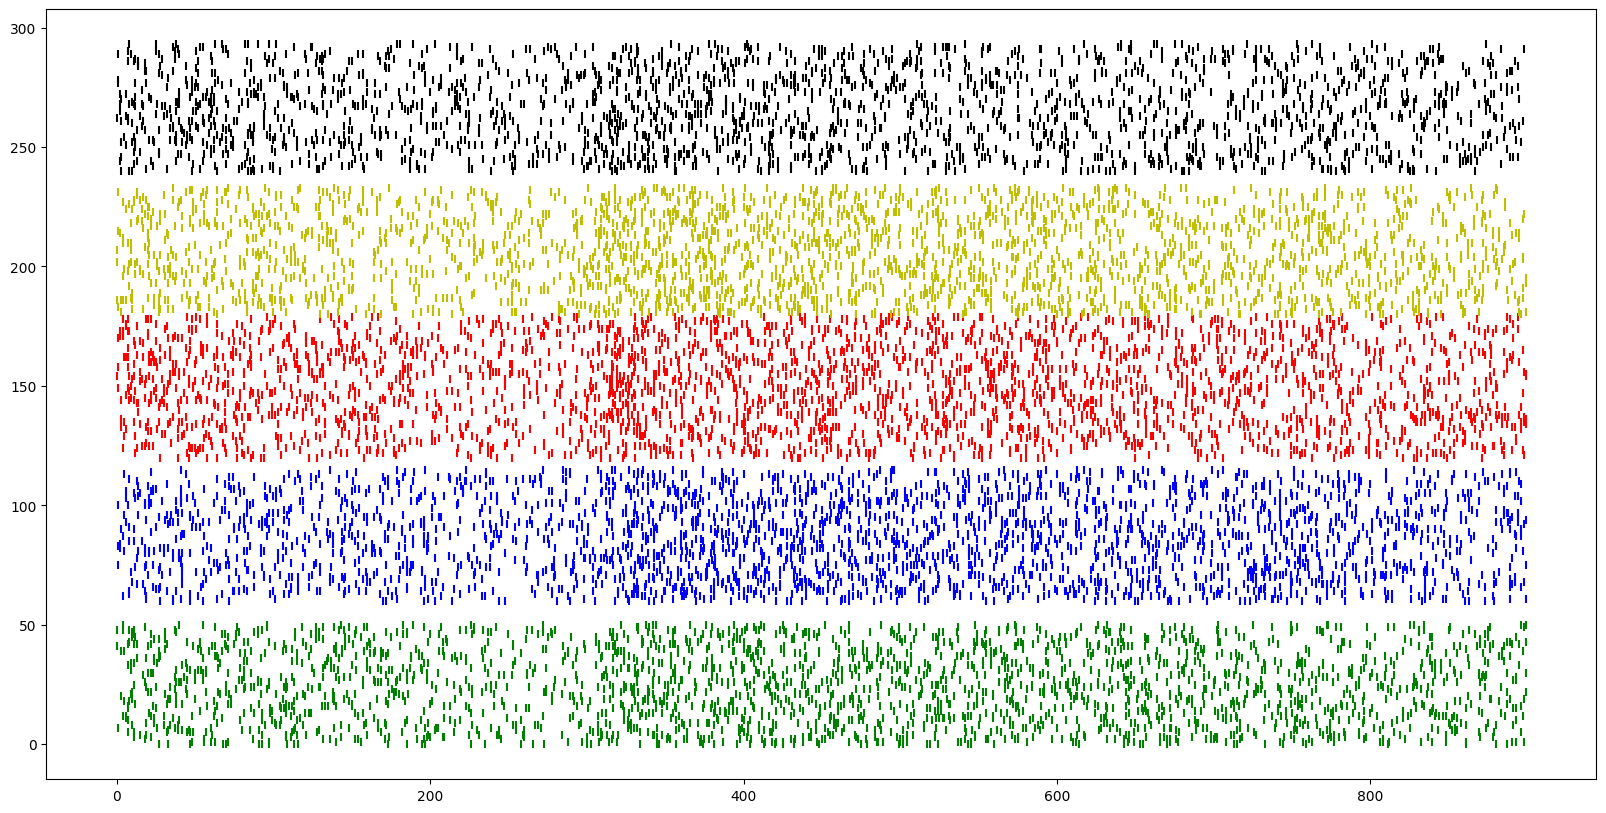

In [11]:
colors=['g','b','r','y','k']
fig, ax = plt.subplots(figsize=(20, 10), sharey=True)
for i,idx in enumerate([o1_c1_idx, o1_c5_idx, o5_c1_idx, o5_c5_idx, o0_c0_idx]):
    rows,cols = np.where(sp_sample_on[idx]==1)
    ax.scatter(cols,rows+60*i, marker='|', alpha=1,edgecolors='none',color=colors[i])

In [ ]:
neu_data.code_samples[mask][np.where(neu_data.code_numbers[mask]==task_constants.EVENTS_B1['sample_on'],True,False)]

array([1582., 1542., 1551., 1539., 1450., 1532., 1696., 1485., 1567.,
       1527., 1379., 1591., 1379., 1551., 1379., 1579., 1779., 1638.,
       1550., 1373., 1473., 1539., 1473., 1521., 1545., 1379., 1650.,
       1720., 1556., 1539., 1579., 1379., 1480., 1421., 1508., 1562.,
       1586., 1508., 1533., 1544., 1592., 1521., 1379., 1510., 1520.,
       1591., 1379., 1579., 1473., 1380., 1379., 1379., 1556., 1380.,
       1557., 1374., 1379., 1497., 1510., 1474., 1562., 1379., 1504.,
       1544., 1380., 1574., 1457., 1380., 1551., 1591., 1380., 1533.,
       1591., 1591., 1473., 1497., 1727., 1520., 1374., 1556., 1379.,
       1379., 1497., 1539., 1591., 1375., 1514., 1551., 1597., 1480.,
       1479., 1520., 1521., 1532., 1586., 1374., 1555., 1568., 1480.,
       1474., 1709., 1379., 1551., 1602., 1755., 1374., 1585., 1550.,
       1379., 1380., 1461., 1508., 1379., 1539., 1503., 1585., 1626.,
       1379., 1379., 1374., 1515., 1649., 1397., 1379., 1586., 1562.,
       1610., 1573.,

In [ ]:
neu_data.code_samples

array([[1000., 1007., 1017., ...,   nan,   nan,   nan],
       [1000., 1003., 1013., ...,   nan,   nan,   nan],
       [1000., 1003., 1009., ..., 4711.,   nan,   nan],
       ...,
       [1000., 1004., 1015., ...,   nan,   nan,   nan],
       [1000., 1003., 1009., ...,   nan,   nan,   nan],
       [1000., 1004., 1010., ..., 5281., 5282.,   nan]])

In [ ]:
neu_data.trial_error

array([5., 0., 0., ..., 4., 3., 4.])

In [ ]:
sp_data.sp_samples.shape

(37, 5893894)

In [ ]:
bhv.code_samples[:2,0].astype(int)

array([1359501, 1361180])

In [19]:
before_trial=1000
iti=1500 
next_trial=6000
trials_end = bhv.code_samples[np.where(bhv.code_numbers==18,True,False)]
trials_start = bhv.code_samples[:,0]
trials_max_duration = max(trials_end-trials_start)
trials_max_duration =int(trials_max_duration + before_trial + iti + next_trial)

In [20]:
n_trials = trials_start.shape[0]
n_neurons = sp_data.sp_samples.shape[0]
tr_sp_data = np.full((n_trials,n_neurons,trials_max_duration),np.nan)

for i_t in range(n_trials):
    start_trial = (trials_start[i_t]-before_trial).astype(int)
    end_trial = (trials_end[i_t]+iti+next_trial).astype(int)
    if end_trial>sp_data.sp_samples.shape[1]:
        end_trial=sp_data.sp_samples.shape[1]
    tr_sp_data[i_t,:,:int(end_trial-start_trial)] = sp_data.sp_samples[:,start_trial:end_trial]
code_samples_trial = bhv.code_samples-bhv.code_samples[:,0].reshape(-1,1)+before_trial


In [22]:
code_samples_trial

array([[1000., 1022., 1151., ...,   nan,   nan,   nan],
       [1000., 1014., 1020., ...,   nan,   nan,   nan],
       [1000., 1014., 1306., ...,   nan,   nan,   nan],
       ...,
       [1000., 1004., 1014., ...,   nan,   nan,   nan],
       [1000., 1004., 1015., ...,   nan,   nan,   nan],
       [1000., 1002., 1015., ...,   nan,   nan,   nan]])

In [23]:
tr_sp_data.shape

(1034, 1, 15198)

In [ ]:
SpikeData.indep_roll(arr=sp_data.sp_samples[:1], shifts=-bhv.code_samples[:1,0].astype(int), axis= 1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
trials_start[0].astype(int)

1359501

In [ ]:
sp_data.sp_samples[:,bhv.code_samples[:,0].astype(int)].shape

(37, 1034)

In [ ]:
sp_data.sp_samples.shape

(37, 5893894)

In [ ]:
5893894-1359501

4534393

In [ ]:
bhv.code_samples[:,0].astype(int)

array([1359501, 1361180, 1364909, ..., 5879458, 5881517, 5883729])

In [ ]:
bhv.code_samples

array([[1359501., 1359523., 1359652., ...,      nan,      nan,      nan],
       [1361180., 1361194., 1361200., ...,      nan,      nan,      nan],
       [1364909., 1364923., 1365215., ...,      nan,      nan,      nan],
       ...,
       [5879458., 5879462., 5879472., ...,      nan,      nan,      nan],
       [5881517., 5881521., 5881532., ...,      nan,      nan,      nan],
       [5883729., 5883731., 5883744., ...,      nan,      nan,      nan]])

In [ ]:
bhv.code_numbers

array([[ 9., 35.,  8., ..., nan, nan, nan],
       [ 9., 35.,  8., ..., nan, nan, nan],
       [ 9., 35.,  8., ..., nan, nan, nan],
       ...,
       [ 9.,  7., 35., ..., nan, nan, nan],
       [ 9.,  7., 35., ..., nan, nan, nan],
       [ 9.,  7., 35., ..., nan, nan, nan]])

In [ ]:
sp_data.sp_samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
40*1000*60

2400000

/tmp/ipykernel_63109/3922085339.py:3: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cols,rows, marker='|', alpha=1,edgecolors='none')


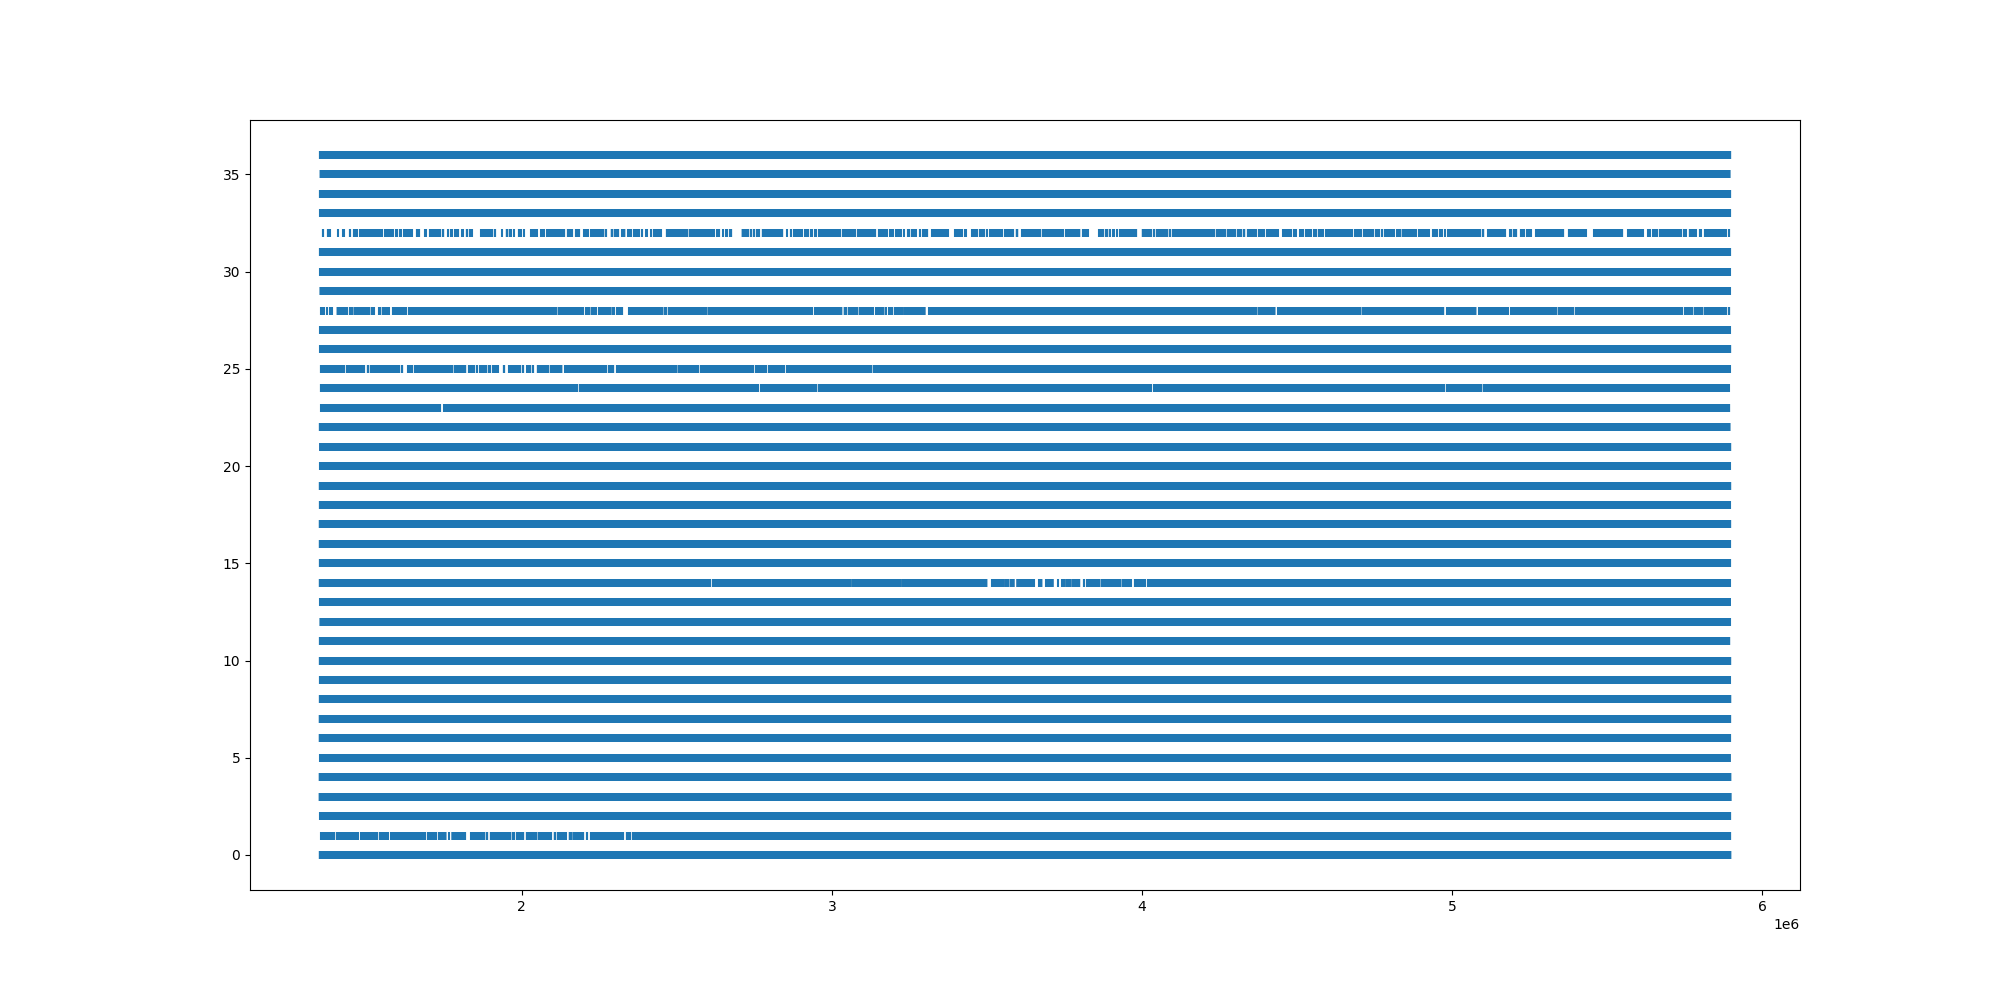

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), sharey=True)
rows,cols = np.where(data.sp_samples==1)
ax.scatter(cols,rows, marker='|', alpha=1,edgecolors='none')

In [ ]:

bhv = BhvData.from_python_hdf5("/home/INT/losada.c/Documents/session_struct/bhv/2023-10-17_11-15-27_Riesling_e1_r1_bhv.h5")

In [ ]:
bhv.sta

AttributeError: 'BhvData' object has no attribute 'cod'

In [ ]:
fix_duration=200
step = 10

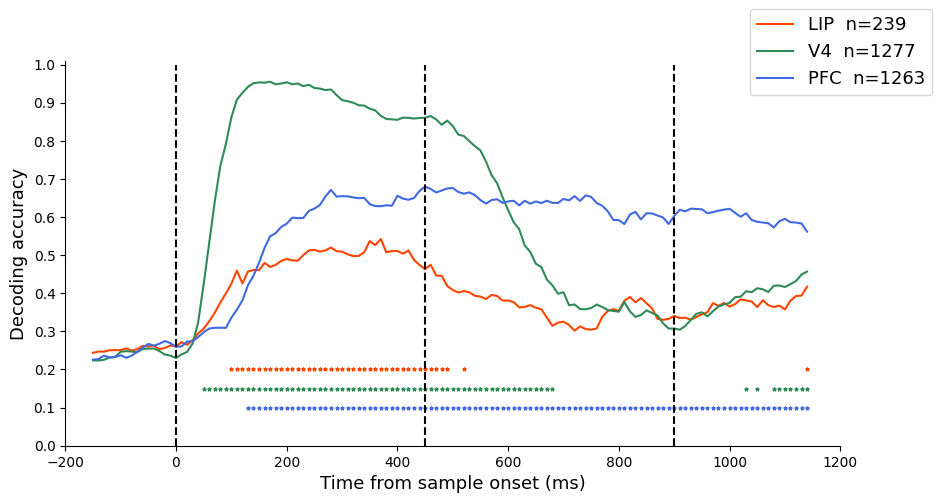

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_samples_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_samples_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_samples_1000it_all_in_win100.npy'
#path_test = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_test.npy'
color=["#ff4500",'seagreen','royalblue']#,'y']
to_decode = "samples"
n_neurs=[239,1277,1263,112]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05 - (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_sample_areas.png",format='png',bbox_inches="tight", transparent=True)
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_sample_areas.svg",format='svg',bbox_inches="tight", transparent=True)

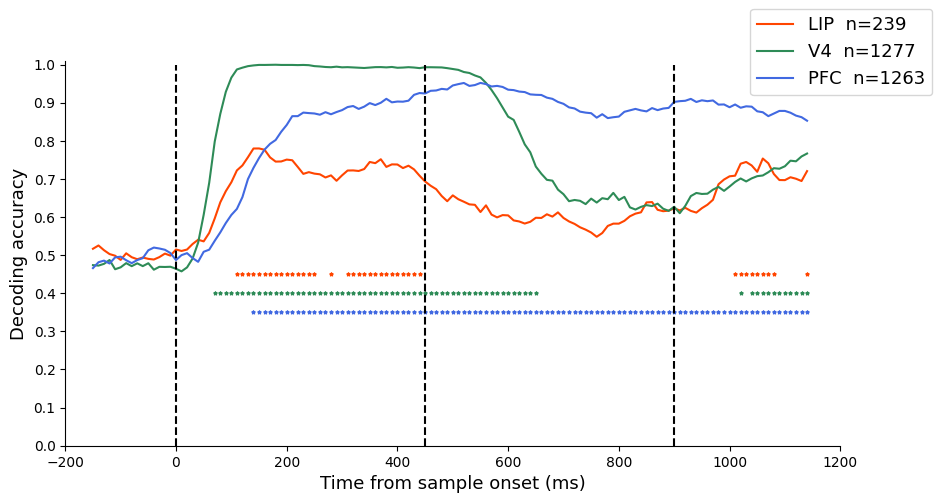

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_orientation_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_orientation_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_orientation_1000it_all_in_win100.npy'
to_decode='orientation'
color=["#ff4500",'seagreen','royalblue']
n_neurs=[239,1277,1263]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05- (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_orientation_areas.png",format='png',bbox_inches="tight", transparent=True)
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_orientation_areas.svg",format='svg',bbox_inches="tight", transparent=True)

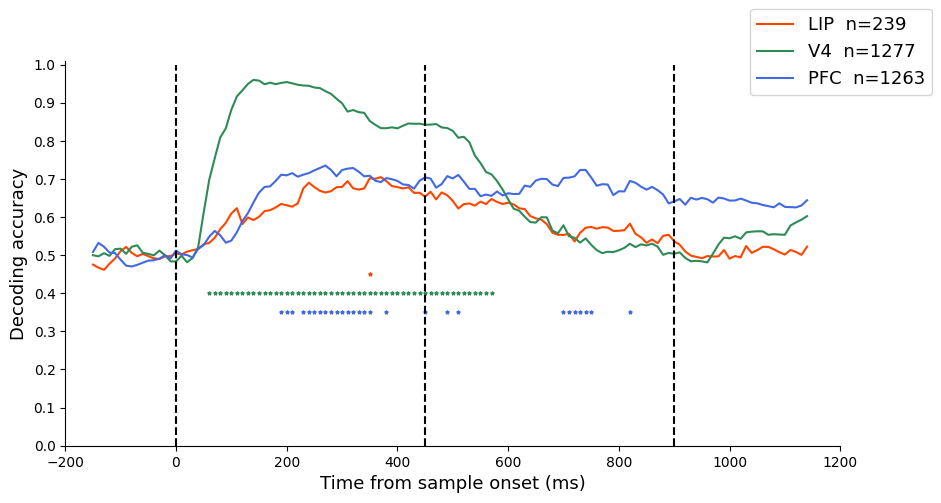

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_colors_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_colors_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_colors_1000it_all_in_win100.npy'
to_decode='colors'
color=["#ff4500",'seagreen','royalblue']
n_neurs=[239,1277,1263]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05- (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

# fig.suptitle(
#     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
#     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
# )

In [ ]:
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_colors_areas.png",format='png',bbox_inches="tight", transparent=True)
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_colors_areas.svg",format='svg',bbox_inches="tight", transparent=True)

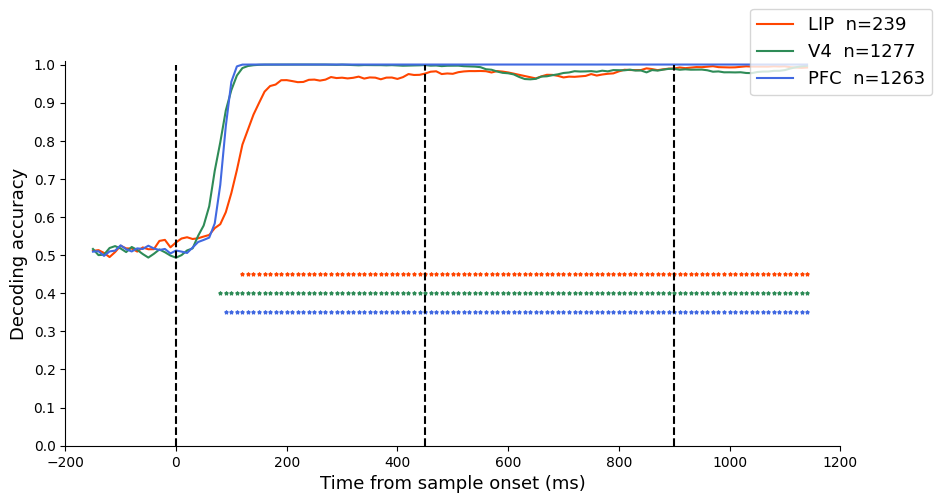

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_neutral_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_neutral_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_neutral_1000it_all_in_win100.npy'
#path_test = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_test.npy'
color=["#ff4500",'seagreen','royalblue']#,'y']
to_decode = "neutral"
n_neurs=[239,1277,1263,112]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05 - (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_neutral_areas.png",format='png',bbox_inches="tight", transparent=True)
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_neutral_areas.svg",format='svg',bbox_inches="tight", transparent=True)